<a href="https://colab.research.google.com/github/georgejordan3/IBM_Capstone/blob/main/Bicycle_Cities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bicycle Cities - Evaluating the Best Cities in the US to Ride a Bicycle

George Jordan <br>
IBM Data Science Professional Certificate Capstone <br>
Last Updated: 3-2-21

<img src="https://www.confluence-denver.com/galleries/Features/2016/Issue_164/bike_lanes_04.jpg">

Credit: [Confluence Denver](https://www.confluence-denver.com/features/denver_bike_lanes_082416.aspx)


## Introduction 
I am a competitive cyclist and moving to Denver was partially motivated by my love for cycling. While I have a strong understanding of the riding experience here, I wonder how my experience compares to other cyclists in various parts of the US. I hope to tell a detailed story of these cities through the eyes of a cyclist and through the lens of data.

In this project, I will examine a list of the highest ranking bicycle cities in the country and apply my own analysis to gain further insight into the cities and their unique characteristics. I will use analytic tools as well as machine learning algorithms to see how these cities relate to each other and also gain insight into other supporting factors that have made these cities accessible via bicycle.

While this project is personally interesting to me, I believe that the insights here could be useful for a variety of business applications. Perhaps there is a company in one of these cities that is considering including provisions to support bike commuters. Maybe the existence of bicycle infrastructure is important to a company and an investigation into potential locations for an office would require such an analysis to foster that kind of culture in the workplace.

I believe that the bicycle is a very powerful tool to not only navigate a city but to also change it, through culture and infrastructure. I hope this project illuminates some of the impact that the bicycle has had on these cities.

## Data 
### PlacesForBikes City Ratings
- [PlacesForBikes City Ratings](https://cityratings.peopleforbikes.org/)

For this project, I will be first looking at the PlacesForBikes ratings to see their list of top cities for bicycles. They have made their data available for the public as well as an explanation to their methodology in ranking. It is from this data that I will select a number of cities to examine further, while also studying their decisions in ranking.

### Foursquare
- [Foursquare](https://foursquare.com/)

I will be using the Foursquare API to get an understanding of the selected cities from the rankings above. The most obvious query would be to find how many bike shops are within the city limits but also some other potential locations to be explored further. This data will be geospatially visualized using mapping libraries in Python.

### Strava
- [Strava](https://www.strava.com/about)

Strava is an app that tracks user's activity files from a variety of sports, including cycling. Strava currently has 55 million users, so there will be no shortage of data to examine in these popular cycling cities. By using the Strava API, I will be able to gain insight into the areas and density of the rides taken within the city.

### Zip Codes
- [Zip-Codes.com](https://www.zip-codes.com/)

In order to organize some this data, I will have to have quick access to a zipcode database for reference. I will use a webscraping tool in this project.

## Methodology 


### Using City Ranking

In [1]:
import pandas as pd
import folium
import requests
import numpy as np
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim

For the City Ratings, I saved the files locally and then uploaded the files into the notebook.

In [2]:
# If I was using a file from some other hosting source, using !wget command would be apporpriate, but it seemed to be a waste of time to host the file online just to demonstrate the ability to upload a file.
pfbr = pd.read_excel("pfbr.xls")

With the data uploaded, getting an idea of the scope of the dataset is an important way to start structuring our analysis.

In [3]:
pfbr.shape

(567, 55)

We'll just be looking at the top ten cities.



In [4]:
top_cities = pfbr.head(10)
top_cities

,Places_ID_2020,City,City_Alt,ACS Bike-to-Work Mode Share,Land Area,Population,ACS Target,ACS Normalized Score,ACS Ridership Points,SMS Recreation Riding,SMS Points,Community Survey Ridership Score,Total Ridership Points,Average Fatalities All Mode,All Mode Fatality Rate,All Mode Fatality Points,Average Fatalities Bike,Bike Fatality Rate,Bike Fatality Points,All Mode Injuries,All Mode Injury Rate,All Mode Injury Points,Bike Injuries,Bike Injury Rate,Bike Injury Points,All mode safety points,Bike Safety Points,Community Survey Safety Score,Total Safety Points,City Snapshot Points,Community Survey Acceleration Score,Total Acceleration Points,BNA,BNA Points,Community Survey Network Score,Total Network Points,Percent Communities of Concern,Number Underserved Communities,Average BNA,BNA Underserved Communities,BNA Gap,BNA Tier,BNA Target,Distance,BNA Points.1,ACS Bike-to-Work Mode Share Men,ACS Bike-to-Work Mode Share Women,ACS Gap,ACS Tier,ACS_Target,Distance.1,ACS Points,Total Reach Points,Bonus,Points with bonus
0,487,"SAN LUIS OBISPO, CALIFORNIA","SAN LUIS OBISPO, CA",0.093,13.1,47160,0.263,28.6,1.4,0.134,2.2,2.8,2.028725,1.2,0.3,4.0,0.2,1.1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.7,2.13888,4.7,3.2,4.35786,61.6,4,3.2,3.83402,5.9,2,49.6,55.2,-5.6,NaN,NaN,NaN,NaN,0.1,0.0,0.1,3.0,-0.6,0.7,2.9,2.864338,0.5,3.544765
1,215,"MADISON, WISCONSIN","MADISON, WI",0.061,78.8,252086,0.115,52.4,2.6,0.182,3.0,3.0,2.863614,8.4,0.3,4.0,0.4,0.6,4.0,84.5,3.4,2.0,8.0,11.7,4.0,3.0,4.0,3.1,3.42080,3.2,3.5,3.25176,49.8,3,3.4,3.08294,11.5,22,47.5,46.2,1.3,1.0,-25.0,26.3,2.2,0.1,0.0,0.0,3.0,-0.6,0.6,3.0,2.431013,0.5,3.510025
2,337,"SANTA BARBARA, CALIFORNIA","SANTA BARBARA, CA",0.052,19.5,91325,0.263,19.3,1.0,0.157,2.6,2.8,1.990605,3.4,0.4,4.0,0.0,0.0,5.0,34.0,3.7,2.0,10.0,48.5,2.0,3.0,3.5,2.7,3.13792,3.8,3.4,3.72760,38.2,2,3.0,2.20700,16.5,16,33.9,36.6,-2.8,1.0,-25.0,22.2,2.7,0.1,0.0,0.1,3.0,-0.6,0.7,3.0,2.733556,0.5,3.259336
3,402,"WASHINGTON, DISTRICT OF COLUMBIA","WASHINGTON, DC",0.097,61.1,684498,0.115,77.5,3.9,0.236,3.9,3.2,3.759195,27.0,0.4,4.0,1.6,1.0,4.0,308.5,4.5,2.0,46.0,28.1,4.0,3.0,4.0,2.3,3.26048,2.2,3.1,2.38442,37.8,2,2.9,2.18248,28.4,128,36.8,31.8,5.0,1.0,-25.0,30.0,1.8,0.1,0.1,0.0,3.0,-0.6,0.6,3.0,2.126418,0.5,3.242599
4,235,"MISSOULA, MONTANA","MISSOULA, MT",0.074,29.3,72125,0.208,34.8,1.7,0.162,2.7,3.1,2.389284,1.8,0.2,4.0,0.0,0.0,5.0,107.5,14.9,0.0,8.0,31.1,3.0,2.0,4.0,2.9,2.98228,2.3,3.5,2.54700,26.1,2,3.7,2.33692,6.6,4,27.5,37.2,-9.7,1.0,-25.0,15.3,3.4,0.1,0.1,0.0,3.0,-0.6,0.6,3.0,3.287384,0.5,3.208574
5,629,"ROGERS, ARKANSAS","ROGERS, AR",0.001,38.2,64947,0.172,0.8,0.0,0.138,2.3,2.4,1.420673,2.4,0.4,4.0,0.0,0.0,5.0,21.0,3.2,3.0,2.0,434.8,0.0,3.5,2.5,3.2,3.04872,4.2,3.4,4.03444,32.7,2,3.6,2.32376,13.0,6,28.6,33.4,-4.8,1.0,-25.0,20.2,2.9,0.0,0.0,0.0,1.0,0.0,0.0,1.9,2.637860,0.5,3.193091
6,132,"FORT COLLINS, COLORADO","FORT COLLINS, CO",0.067,56.7,162511,0.126,50.1,2.5,0.166,2.8,3.0,2.720931,8.4,0.5,3.0,0.4,0.8,4.0,30.5,1.9,4.0,8.0,15.7,4.0,3.5,4.0,3.3,3.65560,1.6,3.8,2.00260,54.9,3,3.8,3.16506,7.3,8,51.3,42.1,9.2,1.0,-25.0,34.2,1.4,0.1,0.1,0.0,3.0,-0.6,0.6,3.1,1.812395,0.5,3.171317
7,101,"DENVER, COLORADO","DENVER, CO",0.029,153.3,693417,0.064,37.2,1.9,0.223,3.7,3.0,2.822340,51.2,0.7,3.0,3.2,3.6,4.0,535.5,7.7,1.0,34.5,39.0,3.0,2.0,3.5,2.4,2.68318,3.3,3.0,3.23406,36.6,2,3.2,2.24832,18.6,111,35.9,32.4,3.5,1.0,-25.0,28.5,2.0,0.0,0.0,0.0,3.0,-0.6,0.6,3.1,2.265968,0.5,3.150774
8,2062,"GRAND FORKS, NORTH DAKOTA","GRAND FORKS, ND",0.014,27.2,56556,0.208,6.3,0.3,0.172,2.9,2.4,1.745181,1.6,0.3,4.0,0.0,0.0,5.0,11.0,1.9,3.0,0.5,12.7,4.0,3.5,4.5,3.0,3.79228,2.1,2.1,2.06044,61.3,4,2.5,3.69718,6.7,3,61.8,54.1,7.7,1.0,-25.0,32.7,1.6,0.0,0.0,0.0,3.0,-0.6,0.6,3.1,1.947318,0.5,3.148480
9,126,"FAYETTEVILLE, ARKANSAS","FAYETTEVILLE, AR",0.013,54.0,83736,0.126,9.6,0.5,0.153,2.5,2.6,1.735982,5.2,0.6,3.0,0.0,0.0,5.0,NaN,NaN,NaN,3.5,70.4,2.0,1.5,3.5,3.2,2.64624,4.9,3.8,4.63192,39.0,2,3.8,2.35232,12.5,7,33.8,24.2,9.5,1.0,-25.0,34.5,1.4,0.0,0.0,0.0,3.0,-0.6,0.

I will use the addresses of the city hall's for each city to serve as the geospatial center for which we can find the coordinates.

In [5]:
san_luis = '990 Palm St, San Luis Obispo, CA 93401'
madison = '2120 Fish Hatchery Rd, Madison, WI 53713'
santa_barbara = '735 Anacapa St, Santa Barbara, CA 93101'
dc = 'First St SE, Washington, DC 20004'
missoula = '435 Ryman St, Missoula, MT 59802'
rogers = '301 W Chestnut St, Rogers, AR 72756'
ft_collins = '300 Laporte Ave, Fort Collins, CO 80521'
denver = '1437 Bannock St, Denver, CO 80202'
grand_forks = '255 N 4th St, Grand Forks, ND 58203'
fayetteville = '113 W Mountain St, Fayetteville, AR 72701'

### Using Foursquare

Using my personalized token, I accessed Foursquare's API making queries into what kind of venues were close to the city halls of these cities. In doing so, I hoped to see if there was any kind of trend that could found in the areas that have high bike riding scores.

In [6]:
CLIENT_ID = 'AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC'
CLIENT_SECRET = 'FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP'
ACCESS_TOKEN = 'ALDECKAYHJJ52RBIX0CCOHA3BSSEU5VPXGA1PTEVRXJTX0GF'
VERSION = '20210228' #Date of query
LIMIT = 30
CODE = 'J5K1MCNFFHAY4YP3LPZHQOY4D400AKRCZOE3R1CH5O4HBGT2#_=_'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC
CLIENT_SECRET:FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP


#### San Luis Obispo

In [7]:
address = san_luis

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

35.28263142857143 -120.66234418367347


In [8]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210228&ll=35.28263142857143,-120.66234418367347&radius=2000&limit=500'

In [9]:
results = requests.get(url).json()

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
san_luis_venues = nearby_venues
san_luis_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Firestone Grill,BBQ Joint,35.281176,-120.660420
1,Louisa's Place,Breakfast Spot,35.280863,-120.661680
2,Scout Coffee Co.,Coffee Shop,35.278963,-120.662836
3,San Luis Obispo Farmers' Market,Farmers Market,35.279390,-120.663637
4,BarrelHouse Brewing SLO - Taproom,Brewery,35.280131,-120.663279


In [12]:
san_luis_categories = san_luis_venues['categories'].value_counts()
san_luis_categories.head()

Sandwich Place        6
Pizza Place           5
Coffee Shop           5
Italian Restaurant    4
Mexican Restaurant    4
Name: categories, dtype: int64

#### Madison

In [13]:
address = madison

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.04292418483257 -89.40407878799554


In [14]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210228&ll=43.04292418483257,-89.40407878799554&radius=2000&limit=500'

In [15]:
results = requests.get(url).json()

In [16]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
madison_venues = nearby_venues
madison_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,KWIK TRIP #531,Convenience Store,43.036830,-89.404930
1,Lane's Bakery & Coffee,Bakery,43.040666,-89.395176
2,El Pastor Restaurant And Bar,Mexican Restaurant,43.043956,-89.394384
3,Taquería Guadalajara,Mexican Restaurant,43.055595,-89.397383
4,Culver's,Fast Food Restaurant,43.036030,-89.415063


In [18]:
madison_categories = madison_venues['categories'].value_counts()
madison_categories.head()

Chinese Restaurant        4
Fast Food Restaurant      4
Sandwich Place            4
Park                      4
Furniture / Home Store    4
Name: categories, dtype: int64

#### Santa Barbara

In [19]:
address = santa_barbara

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

34.420073714285714 -119.6975069387755


In [20]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210228&ll=34.420073714285714,-119.6975069387755&radius=2000&limit=500'

In [21]:
results = requests.get(url).json()

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
santa_barbara_venues = nearby_venues
santa_barbara_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,McConnell's Fine Ice Creams,Ice Cream Shop,34.419388,-119.698888
1,Dune Coffee Roasters,Coffee Shop,34.418816,-119.695372
2,Handlebar Coffee,Coffee Shop,34.422274,-119.698528
3,Santa Barbara Certified Farmers Market,Farmers Market,34.419974,-119.695230
4,Blenders in the Grass,Juice Bar,34.419202,-119.698733


In [24]:
santa_barbara_categories = santa_barbara_venues['categories'].value_counts()
santa_barbara_categories.head()

American Restaurant    5
Brewery                5
Bakery                 5
Mexican Restaurant     5
Coffee Shop            4
Name: categories, dtype: int64

#### Washington DC

In [25]:
address = dc

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

38.8716329 -77.005766


In [26]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210228&ll=38.8716329,-77.005766&radius=2000&limit=500'

In [27]:
results = requests.get(url).json()

In [28]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
dc_venues = nearby_venues
dc_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,The Yards Park,Park,38.873077,-77.001688
1,Nationals Park,Baseball Stadium,38.873261,-77.009679
2,All-Purpose,Pizza Place,38.871005,-77.006556
3,Nationals Clubhouse Team Store,Souvenir Shop,38.874130,-77.006917
4,District CrossFit,Gym,38.871238,-77.010856


In [30]:
dc_categories = dc_venues['categories'].value_counts()
dc_categories.head()

Italian Restaurant    4
Coffee Shop           4
Park                  4
Art Gallery           3
Pizza Place           3
Name: categories, dtype: int64

#### Missoula

In [31]:
address = missoula

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

46.874451949999994 -113.99487574026844


In [32]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210228&ll=46.874451949999994,-113.99487574026844&radius=2000&limit=500'

In [33]:
results = requests.get(url).json()

In [34]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [35]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
missoula_venues = nearby_venues
missoula_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Biga Pizza,Pizza Place,46.871945,-113.997484
1,Liquid Planet,Coffee Shop,46.871900,-113.994259
2,James Bar,Bar,46.874983,-113.993293
3,The Depot,Bar,46.875874,-113.993835
4,Catalyst Cafe & Espresso Bar,Breakfast Spot,46.870628,-113.995108


In [36]:
missoula_categories = missoula_venues['categories'].value_counts()
missoula_categories.head()

Bar            7
Brewery        6
Café           5
Coffee Shop    5
Bakery         5
Name: categories, dtype: int64

#### Rogers

In [37]:
address = rogers

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

36.3347994 -94.1193531


In [38]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210228&ll=36.3347994,-94.1193531&radius=2000&limit=500'

In [39]:
results = requests.get(url).json()

In [40]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [41]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
rogers_venues = nearby_venues
rogers_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,The Rail,Pizza Place,36.331388,-94.116527
1,Susie Q Malt Shop,Burger Joint,36.338225,-94.116815
2,Ozark Beer Co.,Brewery,36.333703,-94.114797
3,Parkside Public,Burger Joint,36.332561,-94.116397
4,Wesner's Grill,Breakfast Spot,36.334278,-94.116833


In [42]:
rogers_categories = rogers_venues['categories'].value_counts()
rogers_categories.head()

Fast Food Restaurant    5
Pizza Place             4
Mexican Restaurant      3
Burger Joint            3
Grocery Store           3
Name: categories, dtype: int64

#### Fort Collins

In [43]:
address = ft_collins

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.5898509 -105.081907325


In [44]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210228&ll=40.5898509,-105.081907325&radius=2000&limit=500'

In [45]:
results = requests.get(url).json()

In [46]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [47]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
ft_collins_venues = nearby_venues
ft_collins_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Snooze,Breakfast Spot,40.587188,-105.078213
1,Beau Jo's,Pizza Place,40.589310,-105.077379
2,Scrumpy's,Bar,40.589335,-105.077173
3,Silver Grill Cafe,Café,40.588695,-105.076388
4,Fort Collins Museum of Discovery,Museum,40.593142,-105.077953


In [48]:
ft_collins_categories = ft_collins_venues['categories'].value_counts()
ft_collins_categories.head()

Coffee Shop            8
Bar                    5
Pizza Place            4
Brewery                4
American Restaurant    4
Name: categories, dtype: int64

#### Denver

In [49]:
address = denver

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

39.73918465 -104.99109381315253


In [50]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210228&ll=39.73918465,-104.99109381315253&radius=2000&limit=500'

In [51]:
results = requests.get(url).json()

In [52]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [53]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
denver_venues = nearby_venues
denver_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Denver Art Museum,Art Museum,39.736479,-104.988712
1,Civic Center Park,Park,39.739370,-104.988776
2,Denver Press Club,Lounge,39.741368,-104.993350
3,Cuba Cuba,Cuban Restaurant,39.735205,-104.993231
4,Local Product of Colorado,Marijuana Dispensary,39.737003,-104.993409


In [54]:
denver_categories = denver_venues['categories'].value_counts()
denver_categories.head()

Hotel                  10
American Restaurant     7
Sandwich Place          6
Italian Restaurant      6
Yoga Studio             3
Name: categories, dtype: int64

#### Grand Forks

In [55]:
address = grand_forks

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

47.9258868 -97.03478493376397


In [56]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210228&ll=47.9258868,-97.03478493376397&radius=2000&limit=500'

In [57]:
results = requests.get(url).json()

In [58]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [59]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
grand_forks_venues = nearby_venues
grand_forks_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Shing Ya,Japanese Restaurant,47.926199,-97.032074
1,Rhombus Guys,Pizza Place,47.924126,-97.029622
2,Sky's Fine Dining and Cloud 9 Lounge,Diner,47.924724,-97.031473
3,The Toasted Frog,American Restaurant,47.926533,-97.032572
4,Widman's Candy Shop,Candy Store,47.924136,-97.028835


In [60]:
grand_forks_categories = grand_forks_venues['categories'].value_counts()
grand_forks_categories.head()

Bar                   12
Pizza Place            5
Sandwich Place         4
Mexican Restaurant     3
Diner                  3
Name: categories, dtype: int64

#### Fayetteville

In [61]:
address = fayetteville

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

36.0616665 -94.16113896362981


In [62]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210228&ll=36.0616665,-94.16113896362981&radius=2000&limit=500'

In [63]:
results = requests.get(url).json()

In [64]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [65]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
fayetteville_venues = nearby_venues
fayetteville_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Hugo's Restaurant,Burger Joint,36.063490,-94.160676
1,Fayetteville Farmers Market,Farmers Market,36.062333,-94.160252
2,A Taste of Thai,Thai Restaurant,36.062573,-94.158676
3,Damgoode Pies,Pizza Place,36.062526,-94.158384
4,Little Bread Company,Bakery,36.064083,-94.160442


In [66]:
fayetteville_categories = fayetteville_venues['categories'].value_counts()
fayetteville_categories.head()

Pizza Place             6
Coffee Shop             4
Fast Food Restaurant    4
Sandwich Place          4
Café                    4
Name: categories, dtype: int64

### Combining the Dataframes

In [67]:
combined = san_luis_venues.append([madison_venues, santa_barbara_venues, dc_venues, missoula_venues, rogers_venues, ft_collins_venues, denver_venues, grand_forks_venues, fayetteville_venues])
combined.shape

(907, 4)

In [107]:
combined_categories = combined['categories'].value_counts()
combined_categories.head(11)

Bar                    39
Coffee Shop            37
Sandwich Place         35
Pizza Place            35
American Restaurant    31
Mexican Restaurant     28
Brewery                27
Hotel                  25
Park                   23
Café                   22
Italian Restaurant     21
Name: categories, dtype: int64

Now that these categories for the top 10 bicycle cities have been counted, I will apply this data to several regression analyses to see if the location categories in these cities can predict the bicycle ranking score. One thing I will need to consider is to avoid overfitting, so there will need to be some testing and consideration going into the categories of venues that will determine the nature of the model.

#### Creating Category Dataframe with Score

In [125]:
data = {'Bar' : ['1, 2, 4, 0, 7, 1, 5, 3, 12, 4'],
        'Pizza Place' : ['5, 1, 3, 3, 3, 4, 4, 1, 5, 6'],
        'Coffee Shop' : ['5, 3, 4, 4, 5, 0, 8, 1, 3, 4'],
        'Sandwich Place' : ['6, 4, 2, 2, 3, 1, 3, 6, 4, 4'],
        'American Restaurant' : ['2, 3, 5, 3, 1, 1, 4, 7, 3, 2'],
        'Mexican Restuarant' : ['4, 2, 5, 2, 3, 3, 2, 2, 3, 2'],
        'Brewery' : ['4, 0, 5, 1, 6, 1, 4, 2, 2, 2'],
        'Hotel' : ['2, 1, 3, 3, 3, 1, 2, 10, 0, 0'],
        'Cafe' : ['3, 0, 2, 2, 5, 1, 4, 1, 0, 4'],
        'Italian Restaurant' : ['4, 0, 0, 4, 1, 0, 2, 6, 3, 1'],
        'Score' : ['3.544765, 3.510025, 3.259336, 3.242599, 3.208574, 3.193091, 3.171317, 3.150774, 3.148480, 3.133023']}
category_score = pd.DataFrame.from_dict(data, orient='columns')
category_score

,Bar,Pizza Place,Coffee Shop,Sandwich Place,American Restaurant,Mexican Restuarant,Brewery,Hotel,Cafe,Italian Restaurant,Score
0,"1, 2, 4, 0, 7, 1, 5, 3, 12, 4","5, 1, 3, 3, 3, 4, 4, 1, 5, 6","5, 3, 4, 4, 5, 0, 8, 1, 3, 4","6, 4, 2, 2, 3, 1, 3, 6, 4, 4","2, 3, 5, 3, 1, 1, 4, 7, 3, 2","4, 2, 5, 2, 3, 3, 2, 2, 3, 2","4, 0, 5, 1, 6, 1, 4, 2, 2, 2","2, 1, 3, 3, 3, 1, 2, 10, 0, 0","3, 0, 2, 2, 5, 1, 4, 1, 0, 4","4, 0, 0, 4, 1, 0, 2, 6, 3, 1","3.544765, 3.510025, 3.259336, 3.242599, 3.2085..."


In [117]:
fayetteville_venues['categories'].value_counts().head(60)

Pizza Place                 6
Coffee Shop                 4
Fast Food Restaurant        4
Sandwich Place              4
Café                        4
Thai Restaurant             4
Bar                         4
Park                        3
Pharmacy                    3
American Restaurant         2
Diner                       2
Video Store                 2
Boutique                    2
Plaza                       2
Brewery                     2
Mexican Restaurant          2
BBQ Joint                   2
Salon / Barbershop          2
Gas Station                 2
Grocery Store               2
Juice Bar                   1
Bagel Shop                  1
Thrift / Vintage Store      1
Sculpture Garden            1
Italian Restaurant          1
Asian Restaurant            1
Frozen Yogurt Shop          1
College Football Field      1
Student Center              1
Automotive Shop             1
Gym                         1
Bakery                      1
Tea Room                    1
Burger Joi

Another model that could be implented is utilizing k-nearest neighbors to compare the 'distance' of cities from the highest ranking cities, based on the category of the closest venues in the cities.

### Plotting

Below are plotting maps for each city. While not directly related to the construction of a regression model, having this data visually presented can provide some interesting insights, such as the shape and layout of the cities. A clustering model of the different venues may provide interesting insights into the segmentation of the city.

#### San Luis Obispo

In [70]:
san_luis_map = folium.Map(location=[35.28263142857143, -120.66234418367347], zoom_start=15)
san_luis_points = san_luis_venues[['lat', 'lng']]

san_luis = san_luis_points.values.tolist()
for point in range(0, len(san_luis)):
  folium.Marker(san_luis[point]).add_to(san_luis_map)
san_luis_map

#### Madison

In [71]:
madison_map = folium.Map(location=[43.04292418483257, -89.40407878799554], zoom_start=15)
madison_points = madison_venues[['lat', 'lng']]

madison = madison_points.values.tolist()
for point in range(0, len(madison)):
  folium.Marker(madison[point]).add_to(madison_map)
madison_map

#### Santa Barbara

In [72]:
santa_barbara_map = folium.Map(location=[34.420073714285714, -119.6975069387755], zoom_start=15)
santa_barbara_points = santa_barbara_venues[['lat', 'lng']]

santa_barbara = santa_barbara_points.values.tolist()
for point in range(0, len(santa_barbara)):
  folium.Marker(santa_barbara[point]).add_to(santa_barbara_map)
santa_barbara_map

#### Washington DC

In [73]:
dc_map = folium.Map(location=[38.8716329, -77.005766], zoom_start=15)
dc_points = dc_venues[['lat', 'lng']]

dc = dc_points.values.tolist()
for point in range(0, len(dc)):
  folium.Marker(dc[point]).add_to(dc_map)
dc_map

#### Missoula

In [74]:
missoula_map = folium.Map(location=[46.874451949999994, -113.99487574026844], zoom_start=15)
missoula_points = missoula_venues[['lat', 'lng']]

missoula = missoula_points.values.tolist()
for point in range(0, len(missoula)):
  folium.Marker(missoula[point]).add_to(missoula_map)
missoula_map

#### Rogers

In [75]:
rogers_map = folium.Map(location=[36.3347994, -94.1193531], zoom_start=15)
rogers_points = rogers_venues[['lat', 'lng']]

rogers = rogers_points.values.tolist()
for point in range(0, len(rogers)):
  folium.Marker(rogers[point]).add_to(rogers_map)
rogers_map

#### Ft. Collins

In [76]:
ft_collins_map = folium.Map(location=[40.5898509, -105.081907325], zoom_start=15)
ft_collins_points = ft_collins_venues[['lat', 'lng']]

ft_collins = ft_collins_points.values.tolist()
for point in range(0, len(ft_collins)):
  folium.Marker(ft_collins[point]).add_to(ft_collins_map)
ft_collins_map

#### Denver

In [77]:
denver_map = folium.Map(location=[39.73918465, -104.99109381315253], zoom_start=15)
denver_points = denver_venues[['lat', 'lng']]

denver = denver_points.values.tolist()
for point in range(0, len(denver)):
  folium.Marker(denver[point]).add_to(denver_map)
denver_map

#### Grand Forks

In [78]:
grand_forks_map = folium.Map(location=[47.9258868, -97.03478493376397], zoom_start=15)
grand_forks_points = grand_forks_venues[['lat', 'lng']]

grand_forks = grand_forks_points.values.tolist()
for point in range(0, len(grand_forks)):
  folium.Marker(grand_forks[point]).add_to(grand_forks_map)
grand_forks_map

#### Fayetteville

In [79]:
fayetteville_map = folium.Map(location=[36.0616665, -94.16113896362981], zoom_start=15)
fayetteville_points = fayetteville_venues[['lat', 'lng']]

fayetteville = fayetteville_points.values.tolist()
for point in range(0, len(fayetteville)):
  folium.Marker(fayetteville[point]).add_to(fayetteville_map)
fayetteville_map

### Regression

In [80]:
from sklearn import linear_model

#### Simple Linear Regression

#### Multiple Linear Regression

Independent Variable: Points with Bonus <br>
Dependent Variables: Kinds of Venues in that city

0


#### Non-Linear Regression

## Results

## Discussion

## Conclusion

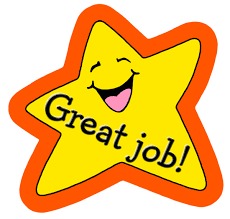